In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

# Define our imshow function 
def imshow(title = "Image", image = None, size = 10):
    w, h = image.shape[0], image.shape[1]
    aspect_ratio = w/h
    plt.figure(figsize=(size * aspect_ratio,size))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.show()

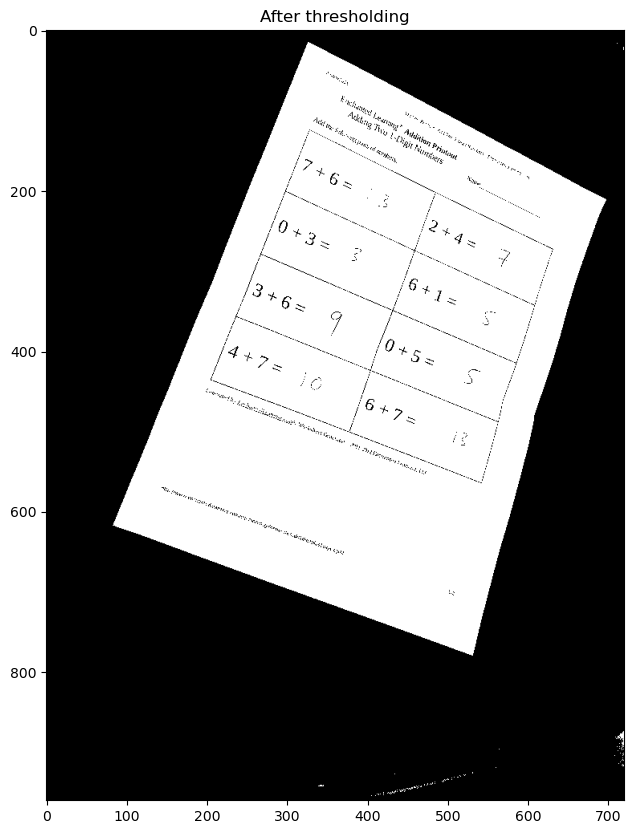

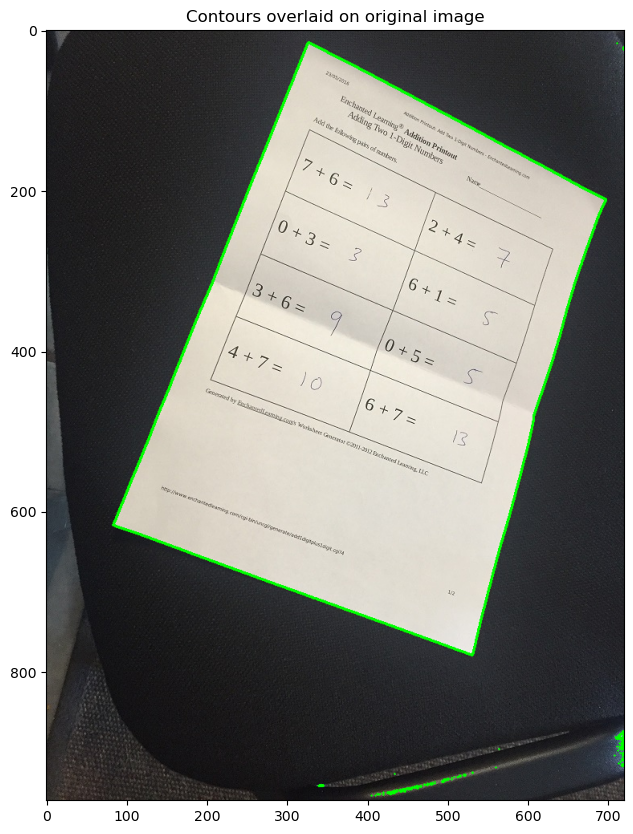

Number of Contours found = 54


In [2]:
image = cv2.imread('images/scan.jpg')

# Convert to Grayscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

_, th2 = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
imshow('After thresholding', th2)

# Use a copy of your image e.g. edged.copy(), since findContours alters the image
contours, hierarchy = cv2.findContours(th2, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Draw all contours, note this overwrites the input image (inplace operation)
# Use '-1' as the 3rd parameter to draw all
cv2.drawContours(image, contours, -1, (0,255,0), thickness = 2)
imshow('Contours overlaid on original image', image)

print("Number of Contours found = " + str(len(contours)))

### **Approxiamte our contour above to just 4 points using approxPolyDP**

In [3]:
# Sort contours large to small by area

sorted_contours = sorted(contours, key=cv2.contourArea, reverse=True)

# loop over the contours
for cnt in sorted_contours:
	# approximate the contour
	perimeter = cv2.arcLength(cnt, True)
	approx = cv2.approxPolyDP(cnt, 0.05 * perimeter, True)
 
	if len(approx) == 4:
		break

# Our x, y cordinates of the four corners 
print("Our 4 corner points are:")
print(approx)



Our 4 corner points are:
[[[326  15]]

 [[ 83 617]]

 [[531 779]]

 [[697 211]]]


### **Use getPerspectiveTransform and warpPerspective to create our top down view**

Note: We mannauly matched the order of the points

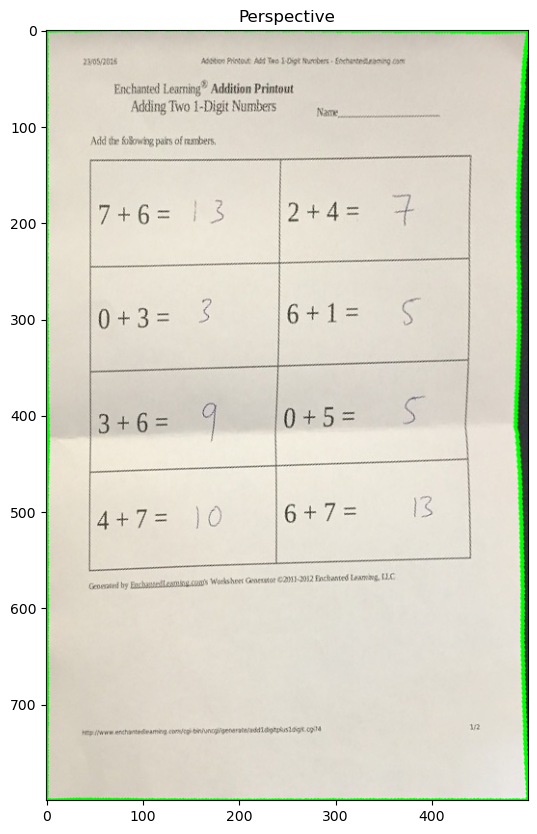

In [4]:
# Order obtained here is top left, bottom left, bottom right, top right
inputPts = np.float32(approx)

outputPts = np.float32([[0,0],
                       [0,800],
                       [500,800],
                       [500,0]])

# Get our Transform Matrix, M
M = cv2.getPerspectiveTransform(inputPts,outputPts)

# Apply the transform Matrix M using Warp Perspective
dst = cv2.warpPerspective(image, M, (500,800))

imshow("Perspective", dst)

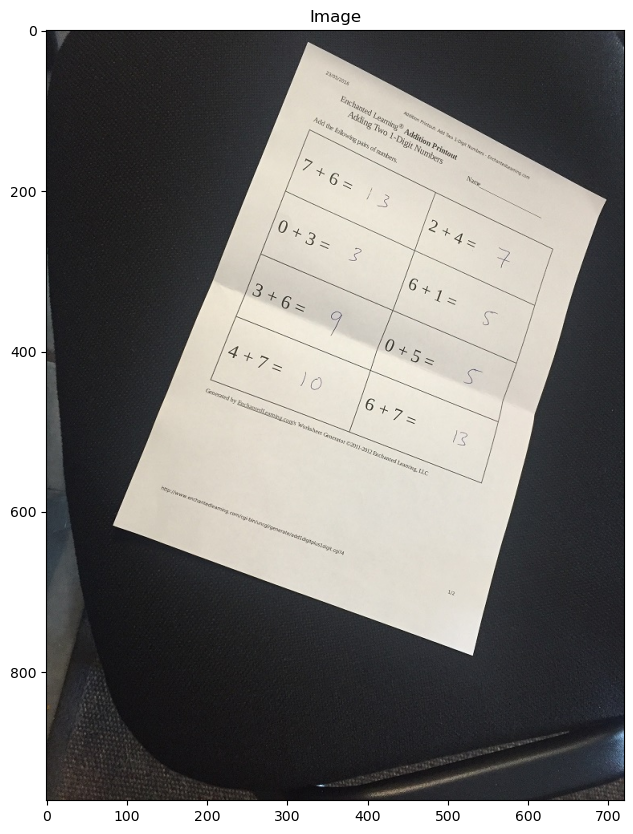

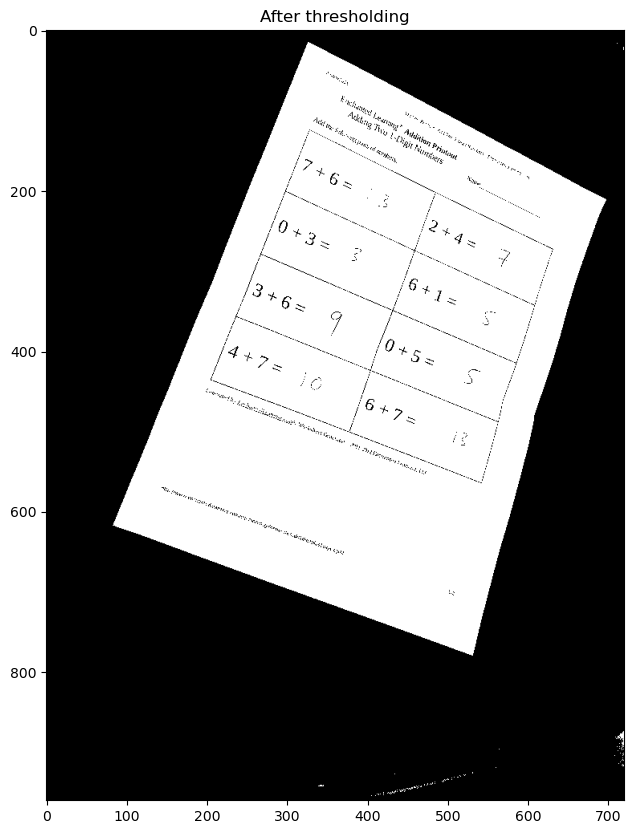

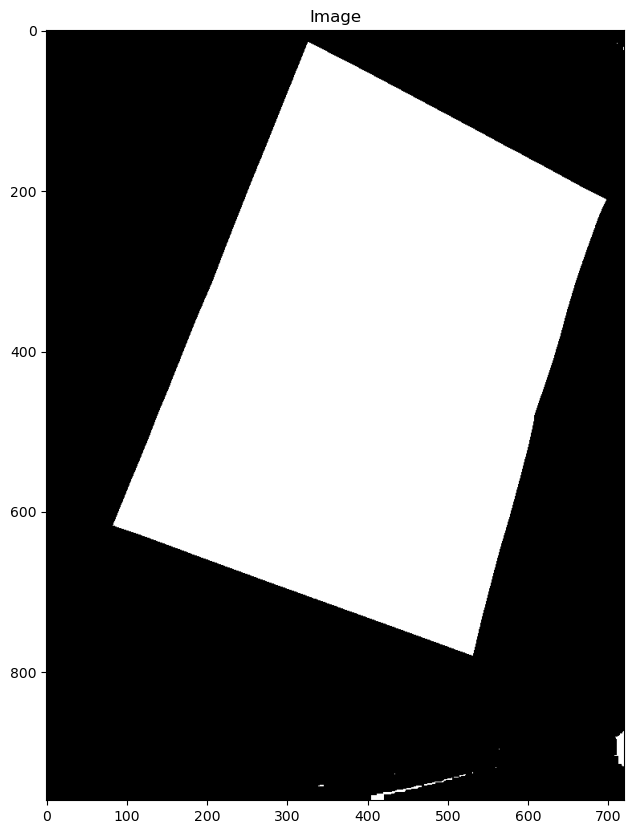

In [22]:
image = cv2.imread('images/scan.jpg')
imshow(image=image)
# Repeated Closing operation to remove text from the document.
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

_, th2 = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
imshow('After thresholding', th2)
kernel = np.ones((5,5),np.uint8)
img = cv2.morphologyEx(th2, cv2.MORPH_CLOSE, kernel, iterations= 3)
img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
imshow(image=img)

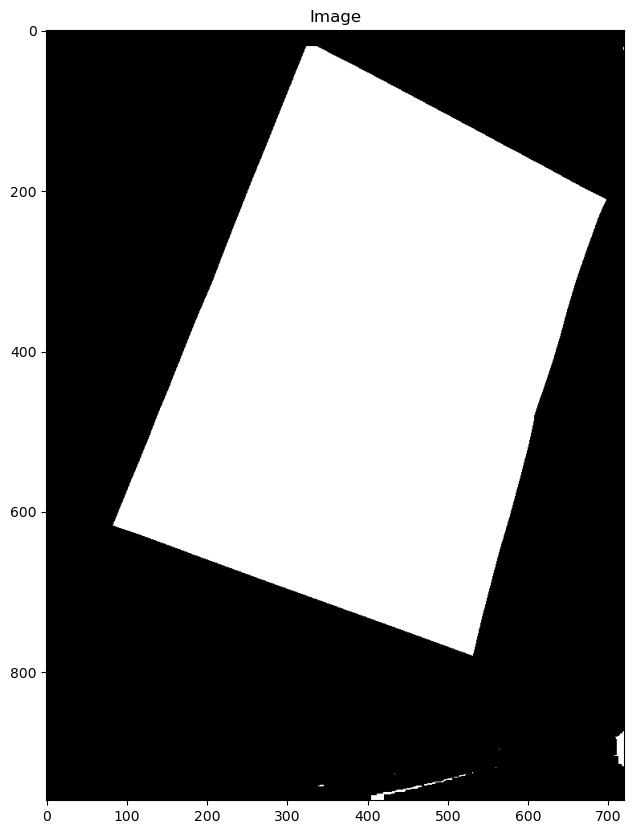

In [23]:
mask = np.zeros(img.shape[:2],np.uint8)
bgdModel = np.zeros((1,65),np.float64)
fgdModel = np.zeros((1,65),np.float64)
rect = (20,20,img.shape[1]-20,img.shape[0]-20)
cv2.grabCut(img,mask,rect,bgdModel,fgdModel,5,cv2.GC_INIT_WITH_RECT)
mask2 = np.where((mask==2)|(mask==0),0,1).astype('uint8')
img = img*mask2[:,:,np.newaxis]
imshow(image=img)

In [24]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
gray = cv2.GaussianBlur(gray, (11, 11), 0)
# Edge Detection.
canny = cv2.Canny(gray, 0, 200)
canny = cv2.dilate(canny, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5)))


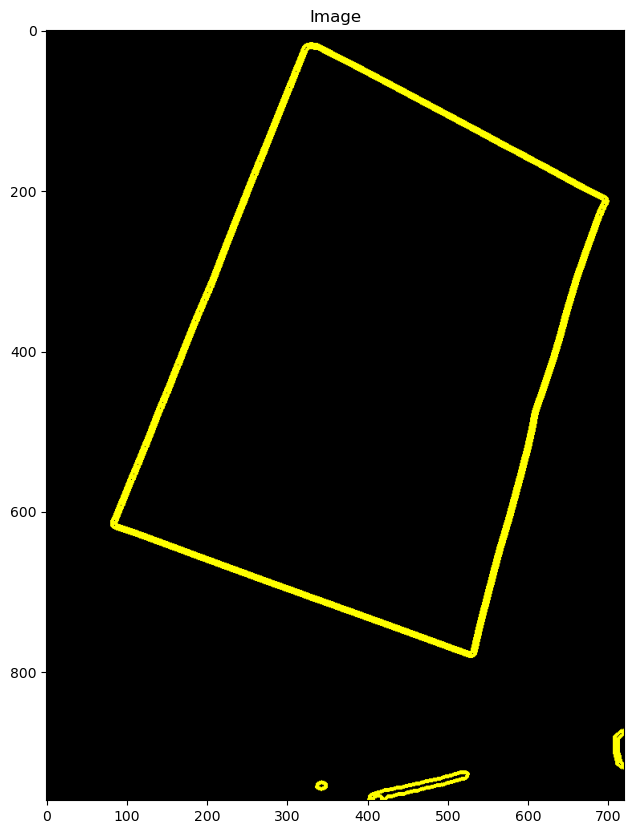

In [30]:
# Blank canvas.
con_img = np.zeros_like(img)
# Finding contours for the detected edges.
contours_2, hierarchy = cv2.findContours(canny, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
# Keeping only the largest detected contour.
page = sorted(contours_2, key=cv2.contourArea, reverse=True)[:5]
con = cv2.drawContours(con_img, page, -1, (0, 255, 255), 3)
imshow(image=con_img)

In [31]:
sorted_contours = sorted(contours_2, key=cv2.contourArea, reverse=True)

# loop over the contours
for cnt in sorted_contours:
	# approximate the contour
	perimeter = cv2.arcLength(cnt, True)
	approx = cv2.approxPolyDP(cnt, 0.05 * perimeter, True)
 
	if len(approx) == 4:
		break

# Our x, y cordinates of the four corners 
print("Our 4 corner points are:")
print(approx)

Our 4 corner points are:
[[[324  18]]

 [[ 82 618]]

 [[531 780]]

 [[699 212]]]


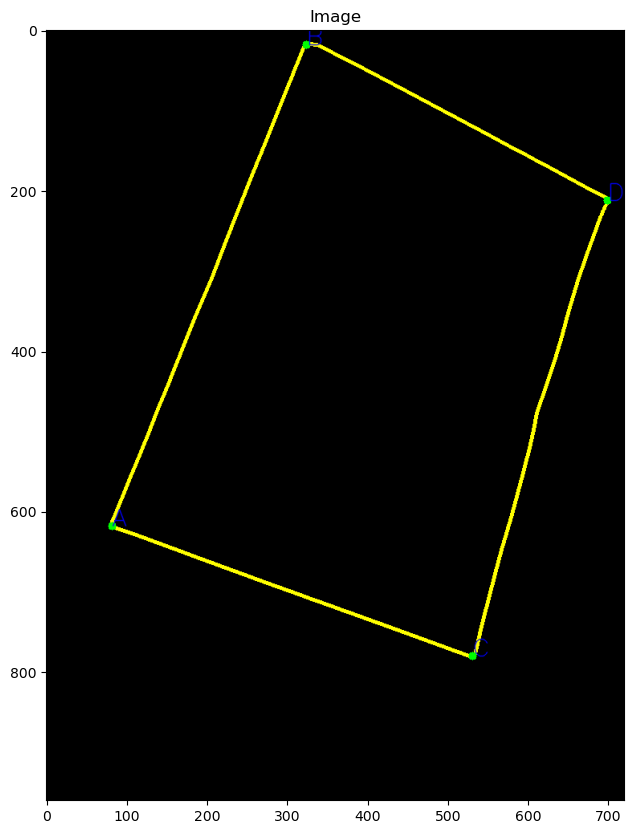

In [32]:
# Blank canvas.
con = np.zeros_like(img)
# Loop over the contours.
for c in page:
  # Approximate the contour.
  epsilon = 0.02 * cv2.arcLength(c, True)
  corners = cv2.approxPolyDP(c, epsilon, True)
  # If our approximated contour has four points
  if len(corners) == 4:
      break
cv2.drawContours(con, c, -1, (0, 255, 255), 3)
cv2.drawContours(con, corners, -1, (0, 255, 0), 10)
# Sorting the corners and converting them to desired shape.
corners = sorted(np.concatenate(corners).tolist())
 
# Displaying the corners.
for index, c in enumerate(corners):
  character = chr(65 + index)
  cv2.putText(con, character, tuple(c), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 1, cv2.LINE_AA)
imshow(image=con)

In [33]:

def order_points(pts):
    '''Rearrange coordinates to order:
      top-left, top-right, bottom-right, bottom-left'''
    rect = np.zeros((4, 2), dtype='float32')
    pts = np.array(pts)
    s = pts.sum(axis=1)
    # Top-left point will have the smallest sum.
    rect[0] = pts[np.argmin(s)]
    # Bottom-right point will have the largest sum.
    rect[2] = pts[np.argmax(s)]
 
    diff = np.diff(pts, axis=1)
    # Top-right point will have the smallest difference.
    rect[1] = pts[np.argmin(diff)]
    # Bottom-left will have the largest difference.
    rect[3] = pts[np.argmax(diff)]
    # Return the ordered coordinates.
    return rect.astype('int').tolist()



In [35]:
pts = order_points(corners)
print(pts)

[[324, 18], [699, 212], [531, 780], [82, 618]]


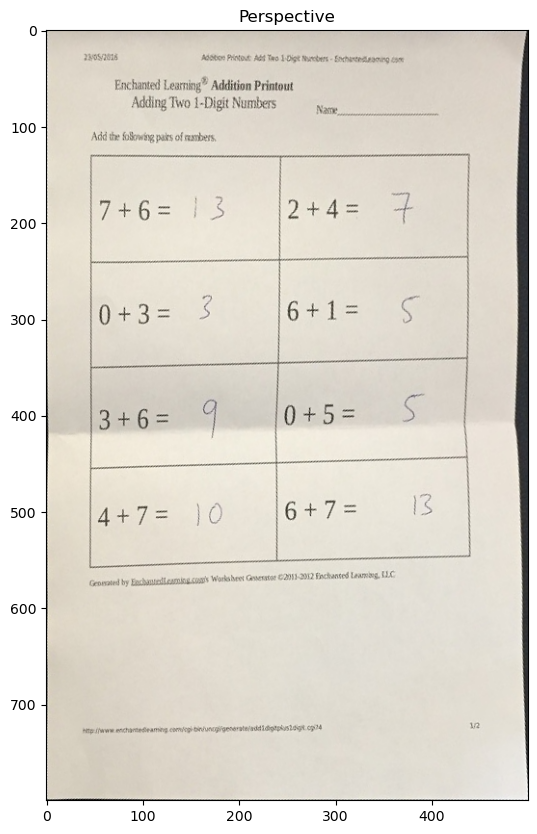

In [39]:
# Order obtained here is top left, bottom left, bottom right, top right
inputPts = np.float32(pts)

outputPts = np.float32([[0,0],
                        [500,0],
                        [500,800],
                        [0,800]])

# Get our Transform Matrix, M
M = cv2.getPerspectiveTransform(inputPts,outputPts)

# Apply the transform Matrix M using Warp Perspective
dst = cv2.warpPerspective(image, M, (500,800))

imshow("Perspective", dst)

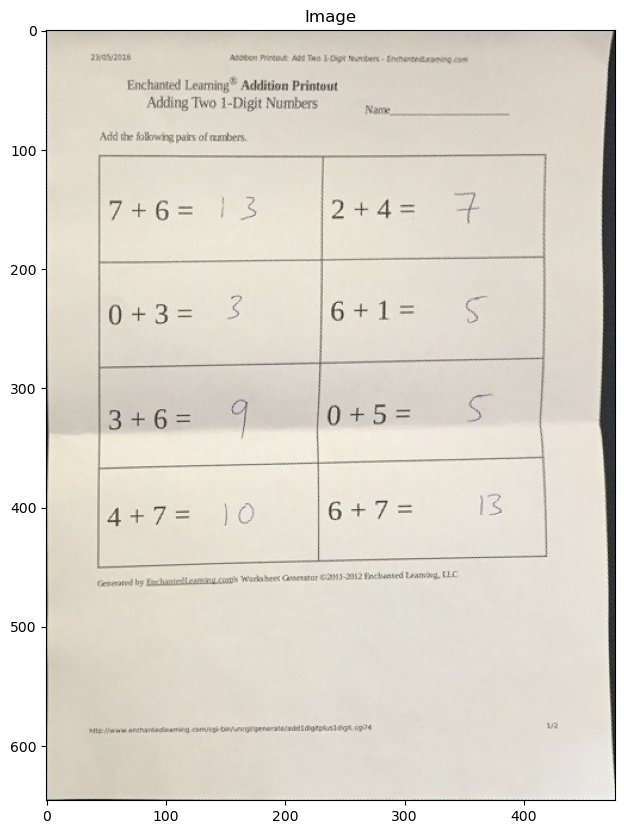

In [40]:

(tl, tr, br, bl) = pts
# Finding the maximum width.
widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
maxWidth = max(int(widthA), int(widthB))
# Finding the maximum height.
heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
maxHeight = max(int(heightA), int(heightB))
# Final destination co-ordinates.
destination_corners = [[0, 0], [maxWidth, 0], [maxWidth, maxHeight], [0, maxHeight]]


# Getting the homography.
M = cv2.getPerspectiveTransform(np.float32(pts), np.float32(destination_corners))
# Perspective transform using homography.
final = cv2.warpPerspective(image, M, (destination_corners[2][0], destination_corners[2][1]), flags=cv2.INTER_LINEAR)
imshow(image=final)

In [15]:
def order_points(pts):
    '''Rearrange coordinates to order:
      top-left, top-right, bottom-right, bottom-left'''
    rect = np.zeros((4, 2), dtype='float32')
    pts = np.array(pts)
    s = pts.sum(axis=1)
    # Top-left point will have the smallest sum.
    rect[0] = pts[np.argmin(s)]
    # Bottom-right point will have the largest sum.
    rect[2] = pts[np.argmax(s)]
 
    diff = np.diff(pts, axis=1)
    # Top-right point will have the smallest difference.
    rect[1] = pts[np.argmin(diff)]
    # Bottom-left will have the largest difference.
    rect[3] = pts[np.argmax(diff)]
    # Return the ordered coordinates.
    return rect.astype('int').tolist()

In [16]:
def find_dest(pts):
    (tl, tr, br, bl) = pts
    # Finding the maximum width.
    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    maxWidth = max(int(widthA), int(widthB))
 
    # Finding the maximum height.
    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    maxHeight = max(int(heightA), int(heightB))
    # Final destination co-ordinates.
    destination_corners = [[0, 0], [maxWidth, 0], [maxWidth, maxHeight], [0, maxHeight]]
 
    return order_points(destination_corners)

In [17]:
def scan(img):
    # Resize image to workable size
    dim_limit = 1080
    max_dim = max(img.shape)
    if max_dim > dim_limit:
        resize_scale = dim_limit / max_dim
        img = cv2.resize(img, None, fx=resize_scale, fy=resize_scale)
    # Create a copy of resized original image for later use
    orig_img = img.copy()
    # Repeated Closing operation to remove text from the document.
    kernel = np.ones((5, 5), np.uint8)
    img = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel, iterations=3)
    # GrabCut
    mask = np.zeros(img.shape[:2], np.uint8)
    bgdModel = np.zeros((1, 65), np.float64)
    fgdModel = np.zeros((1, 65), np.float64)
    rect = (20, 20, img.shape[1] - 20, img.shape[0] - 20)
    cv2.grabCut(img, mask, rect, bgdModel, fgdModel, 5, cv2.GC_INIT_WITH_RECT)
    mask2 = np.where((mask == 2) | (mask == 0), 0, 1).astype('uint8')
    img = img * mask2[:, :, np.newaxis]
 
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (11, 11), 0)
    # Edge Detection.
    canny = cv2.Canny(gray, 0, 200)
    canny = cv2.dilate(canny, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5)))
 
    # Finding contours for the detected edges.
    contours, hierarchy = cv2.findContours(canny, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
    # Keeping only the largest detected contour.
    page = sorted(contours, key=cv2.contourArea, reverse=True)[:5]
 
    # Detecting Edges through Contour approximation.
    # Loop over the contours.
    if len(page) == 0:
        return orig_img
    for c in page:
        # Approximate the contour.
        epsilon = 0.02 * cv2.arcLength(c, True)
        corners = cv2.approxPolyDP(c, epsilon, True)
        # If our approximated contour has four points.
        if len(corners) == 4:
            break
    # Sorting the corners and converting them to desired shape.
    corners = sorted(np.concatenate(corners).tolist())
    # For 4 corner points being detected.
    corners = order_points(corners)
 
    destination_corners = find_dest(corners)
 
    h, w = orig_img.shape[:2]
    # Getting the homography.
    M = cv2.getPerspectiveTransform(np.float32(corners), np.float32(destination_corners))
    # Perspective transform using homography.
    final = cv2.warpPerspective(orig_img, M, (destination_corners[2][0], destination_corners[2][1]),
                                flags=cv2.INTER_LINEAR)
    return final


In [21]:
image = cv2.imread('images/scan.jpg')
pts = scan(image)



(tl, tr, br, bl) = pts
# Finding the maximum width.
widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
maxWidth = max(int(widthA), int(widthB))
# Finding the maximum height.
heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
maxHeight = max(int(heightA), int(heightB))
# Final destination co-ordinates.
destination_corners = [[0, 0], [maxWidth, 0], [maxWidth, maxHeight], [0, maxHeight]]


# Getting the homography.
M = cv2.getPerspectiveTransform(np.float32(corners), np.float32(destination_corners))
# Perspective transform using homography.
final = cv2.warpPerspective(image, M, (destination_corners[2][0], destination_corners[2][1]), flags=cv2.INTER_LINEAR)

ValueError: too many values to unpack (expected 4)